In [1]:
import os
import glob
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import mobilenet_v2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, Dropout, GlobalAveragePooling2D, Dense, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, ReduceLROnPlateau

seed_number = 24
np.random.seed(seed_number)
tf.random.set_seed(seed_number)

In [2]:
root = "C:/Users/user/Desktop/FYP/3d_face_spoofing"
input_dir = os.path.join(root,"lcc-fasd-dataset-balanced")
train_dir = os.path.join(input_dir, 'LCC_FASD_training')
val_dir = os.path.join(input_dir, 'LCC_FASD_development')
test_dir = os.path.join(input_dir, 'LCC_FASD_evaluation')

dataset_dir = [dir for dir in sorted(os.listdir(input_dir)) if os.path.isdir(os.path.join(input_dir, dir))]
label_name = [subdir for subdir in sorted(os.listdir(train_dir)) if os.path.isdir(os.path.join(train_dir, subdir))]

print(f"Main directories\t: {os.listdir(root)}")
print(f"Dataset sub-directories\t: {dataset_dir}")
print(f"Train set directory\t: {label_name}")

Main directories	: ['.DS_Store', '.env', '.git', '.gitignore', 'data', 'fyp-face-antispoofing.zip', 'gradio-ui', 'lcc-fasd-dataset-balanced', 'LCC_FASD', 'LICENSE', 'notebooks', 'README.md', 'test-images']
Dataset sub-directories	: ['LCC_FASD_development', 'LCC_FASD_evaluation', 'LCC_FASD_training']
Train set directory	: ['real', 'spoof']


In [3]:
dir_dict = {'train': train_dir, 'val': val_dir, 'test': test_dir}
case_count, img_disp, set_length  = {}, {}, {}

for key, val in dir_dict.items():
    case_count[key] = {}
    img_disp[key] = {}
    set_count = 0
    
    for label in label_name:
        label_list = list(sorted(glob.glob(os.path.join(val, label, "*.png"))))
        if len(label_list) == 0:
          continue

        case_count[key][label] = len(label_list)
        set_count += len(label_list)
        
        select_img_id = np.random.randint(len(label_list)-1)
        # print(select_img_id)
        img_disp[key][label] = label_list[select_img_id]
        
    set_length[key] = set_count

case_count_df = pd.DataFrame(case_count)
img_disp_df = pd.DataFrame(img_disp)
print(f"Dataset summary:\n\n{case_count_df}")

Dataset summary:

       train   val  test
real    1363   285   294
spoof  11796  2523  2566


In [4]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   rotation_range = 30,
                                   width_shift_range = 0.3,
                                   height_shift_range = 0.3,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True,
                                   fill_mode="nearest")

val_datagen = ImageDataGenerator(rescale = 1./255)
test_datagen = ImageDataGenerator(rescale=1./255) if set_length["test"] > 0 else None

In [5]:
train_batch_size = 32
val_batch_size = 32
img_width = 224
img_height = 224
# seed_number = 42
train_gen = train_datagen.flow_from_directory(train_dir,
                                              batch_size = train_batch_size,
                                              class_mode = 'binary',
                                              target_size = (img_width, img_height),
                                              seed = seed_number)

val_gen = val_datagen.flow_from_directory(val_dir,
                                          batch_size = val_batch_size,
                                          class_mode = 'binary',
                                          target_size = (img_width, img_height),
                                          seed = seed_number)

if test_datagen is not None:
  test_gen = test_datagen.flow_from_directory(test_dir,
                                              batch_size = 1,
                                              class_mode = 'binary',
                                              target_size = (img_width, img_height),
                                              seed = seed_number,
                                              shuffle=False)
else:
  test_gen = None

Found 13159 images belonging to 2 classes.
Found 2808 images belonging to 2 classes.
Found 2860 images belonging to 2 classes.


In [6]:
print(f'Train set batch shape\t: {next(train_gen)[0].shape}')
print(f'Val set batch shape\t: {next(val_gen)[0].shape}')
print(f'Test set batch shape\t: {next(test_gen)[0].shape}') if test_gen is not None else None

Train set batch shape	: (32, 224, 224, 3)
Val set batch shape	: (32, 224, 224, 3)
Test set batch shape	: (1, 224, 224, 3)


In [7]:
pretrain_net = mobilenet_v2.MobileNetV2(input_shape = (img_width, img_height, 3),
                                        include_top = False,
                                        weights = 'imagenet',
                                        alpha = 0.5)

freeze_before = None  
if freeze_before:
    for layer in pretrain_net.layers:
        if layer.name == freeze_before:
            break
        else:
            layer.trainable = False

In [8]:
x = pretrain_net.output
x = Conv2D(32, (3, 3), activation='relu')(x)
# x = BatchNormalization()(x)
x = Dropout(rate=0.5, name='extra_dropout1')(x)
x = GlobalAveragePooling2D()(x)
x = Dense(units=64, activation='relu', kernel_regularizer=l2(0.01), name='extra_fc1')(x)
x = Dropout(rate=0.5, name='extra_dropout2')(x)
# x = Dense(units=128, activation='relu', name='extra_fc1')(x)
# x = Dropout(rate=0.2, name='extra_dropout1')(x)
x = Dense(1, activation='sigmoid', name='classifier')(x)

model = Model(inputs=pretrain_net.input, outputs=x, name='mobilenetv2_spoof')
print(model.summary())

Model: "mobilenetv2_spoof"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        432 │ input_layer[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │         64 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        144 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │         64 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (Conv2D)            │ 8)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         32 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 8)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │        384 │ expanded_conv_pr… │
│ (Conv2D)            │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        192 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        432 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        192 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │        768 │ block_1_depthwis

 Total params: 1,077,073 (4.11 MB)

 Trainable params: 1,058,529 (4.04 MB)

 Non-trainable params: 18,544 (72.44 KB)

None


In [9]:
train_id = "lcc-train04b-weight_all-corrected-distributed-3"  
num_epochs = 40  
learning_rate = 5e-5  

print(f"Training config of '{train_id}'...")
print(f"Number of epoch\t: {num_epochs}")
print(f"Initial LR\t: {learning_rate}")

model.compile(optimizer = Adam(learning_rate=learning_rate),
              loss = 'binary_crossentropy',
              metrics = ['acc'])

save_dir = os.path.join("./", train_id)
if not os.path.isdir(save_dir):
  os.makedirs(save_dir)

cont_filepath = "mobilenetv2-epoch_{epoch:02d}.keras"
cont_checkpoint = ModelCheckpoint(os.path.join(save_dir, cont_filepath))

best_filepath = "mobilenetv2-best.weights.h5"
best_checkpoint = ModelCheckpoint(os.path.join(save_dir, best_filepath),
                                  save_best_only=True,
                                  save_weights_only=True)

log_dir = os.path.join(save_dir, "logs")
use_tensorboard = TensorBoard(log_dir=log_dir,
                              histogram_freq=1,
                              update_freq="batch")

plateau_scheduler = ReduceLROnPlateau(factor=0.2, patience=3, verbose=1, 
                                      min_delta= 0.005, min_lr=5e-7)


train_length = len(train_gen.classes)
weight0 = train_length / case_count_df['train'][label_name[0]] * (1 / len(label_name))
weight1 = train_length / case_count_df['train'][label_name[1]] * (1 / len(label_name))
class_weight = {0: weight0, 1: weight1}

print(f"Class weight\t: {class_weight}")

Training config of 'lcc-train04b-weight_all-corrected-distributed-3'...
Number of epoch	: 40
Initial LR	: 5e-05
Class weight	: {0: 4.827219369038885, 1: 0.5577738216344523}


In [10]:
history = model.fit(train_gen,
                    epochs = num_epochs,
                    # steps_per_epoch = set_length['train'] // train_batch_size,
                    validation_data = val_gen,
                    # validation_steps = 1,
                    callbacks = [best_checkpoint,
                                 cont_checkpoint,
                                 plateau_scheduler],
                    class_weight=class_weight)

history_df = pd.DataFrame.from_dict(history.history)
history_df.to_csv(os.path.join(save_dir, "history.csv"), index=False)

Epoch 1/40


c:\Users\user\anaconda3\envs\internship\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


412/412 ━━━━━━━━━━━━━━━━━━━━ 1028s 2s/step - acc: 0.6694 - loss: 0.9581 - val_acc: 0.9024 - val_loss: 0.7189 - learning_rate: 5.0000e-05
Epoch 2/40
412/412 ━━━━━━━━━━━━━━━━━━━━ 981s 2s/step - acc: 0.9313 - loss: 0.5341 - val_acc: 0.9380 - val_loss: 0.5072 - learning_rate: 5.0000e-05
Epoch 3/40
412/412 ━━━━━━━━━━━━━━━━━━━━ 990s 2s/step - acc: 0.9556 - loss: 0.4496 - val_acc: 0.9274 - val_loss: 0.6023 - learning_rate: 5.0000e-05
Epoch 4/40
412/412 ━━━━━━━━━━━━━━━━━━━━ 1002s 2s/step - acc: 0.9746 - loss: 0.3585 - val_acc: 0.9509 - val_loss: 0.4220 - learning_rate: 5.0000e-05
Epoch 5/40
412/412 ━━━━━━━━━━━━━━━━━━━━ 1031s 2s/step - acc: 0.9705 - loss: 0.3198 - val_acc: 0.9598 - val_loss: 0.4025 - learning_rate: 5.0000e-05
Epoch 6/40
412/412 ━━━━━━━━━━━━━━━━━━━━ 999s 2s/step - acc: 0.9792 - loss: 0.2645 - val_acc: 0.9138 - val_loss: 0.4292 - learning_rate: 5.0000e-05
Epoch 7/40
412/412 ━━━━━━━━━━━━━━━━━━━━ 989s 2s/step - acc: 0.9767 - loss: 0.2416 - val_acc: 0.9177 - val_loss: 0.4136 - learn

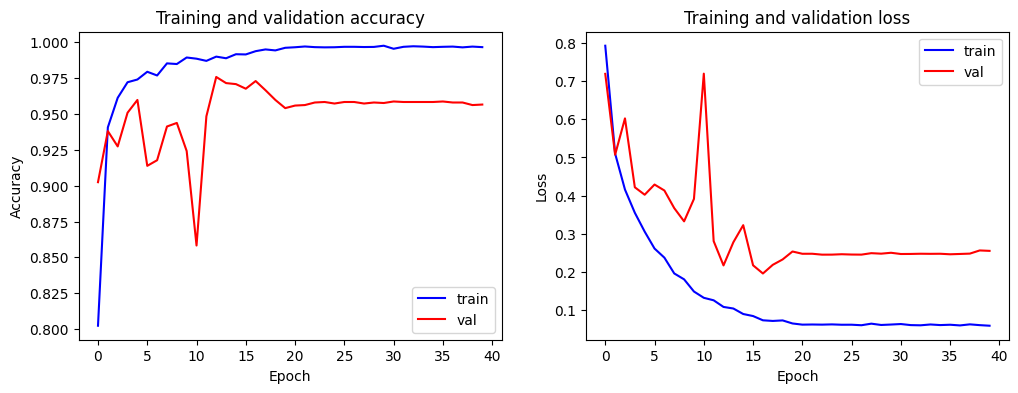

In [11]:
train_accuracy = history.history['acc']
val_accuracy = history.history['val_acc']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(train_accuracy))
plt.figure(figsize=(12,4))


plt.subplot(1,2,1)
plt.plot(epochs, train_accuracy, 'b', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'val'], loc='lower right')


plt.subplot(1,2,2)
plt.plot(epochs, train_loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'val'], loc='upper right')

plt.show()

In [12]:
test_scores = model.evaluate(test_gen, steps=set_length['test'])
print("Test results Accuracy: {0:.2f}%, and Loss: {1:.2f}".format(test_scores[1]*100, test_scores[0]))

threshold = 0.5  
y_pred_value = np.squeeze(model.predict(test_gen, steps=set_length['test'], verbose=1))

y_pred = np.zeros(y_pred_value.shape).astype(np.int32)  # Sigmoid
y_pred[y_pred_value > threshold] = 1

# y_pred = np.argmax(y_pred_value, axis=-1).astype(np.int32)  # Softmax

y_true = test_gen.classes

   5/2860 ━━━━━━━━━━━━━━━━━━━━ 1:16 27ms/step - acc: 0.8433 - loss: 1.9248

c:\Users\user\anaconda3\envs\internship\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


2860/2860 ━━━━━━━━━━━━━━━━━━━━ 53s 18ms/step - acc: 0.9281 - loss: 0.5559
Test results Accuracy: 97.69%, and Loss: 0.21
2860/2860 ━━━━━━━━━━━━━━━━━━━━ 57s 19ms/step


In [13]:
print(f"Label\t\t: {y_true[:50]}")
print(f"Prediction\t: {y_pred[:50]}")

Label		: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0]
Prediction	: [0 0 1 0 0 0 0 0 0 1 1 0 0 1 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1
 0 1 0 0 0 0 1 0 0 0 0 0 0]


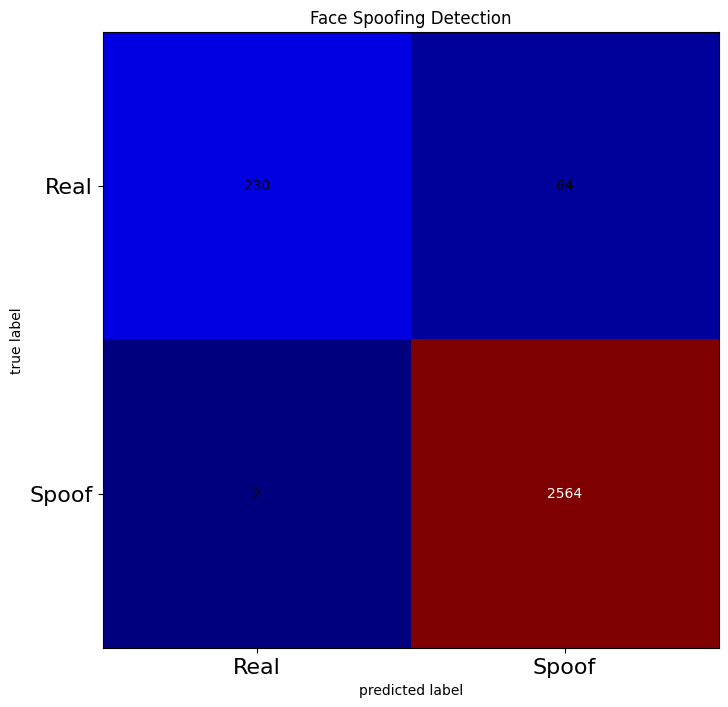

Classification Report:
              precision    recall  f1-score   support

        Real       0.99      0.78      0.87       294
       Spoof       0.98      1.00      0.99      2566

    accuracy                           0.98      2860
   macro avg       0.98      0.89      0.93      2860
weighted avg       0.98      0.98      0.98      2860

Manual Calculation Summary:
Precision	: 97.56%
Recall		: 99.92%
F1 Score	: 98.73%

Notes: 
True labels	: Spoof
False labels	: Real


In [14]:
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import classification_report, confusion_matrix

# Generate confusion matrix
confusion_matrix_result = confusion_matrix(y_true, y_pred)
plot_confusion_matrix(confusion_matrix_result,
                      figsize=(12,8),
                      hide_ticks=True,
                      cmap=plt.cm.jet)
plt.title("Face Spoofing Detection")
plt.xticks(range(2), ['Real', 'Spoof'], fontsize=16)
plt.yticks(range(2), ['Real', 'Spoof'], fontsize=16)
plt.show()

# Calculate and print classification report
report = classification_report(y_true, y_pred, target_names=['Real', 'Spoof'])
print("Classification Report:")
print(report)

# Manually calculate precision, recall, and F1 score for further inspection
tn, fp, fn, tp = confusion_matrix_result.ravel()
precision = tp / (tp+fp)
recall = tp / (tp+fn)
f1_score = 2 * precision * recall / (precision+recall)

print("Manual Calculation Summary:")
print("Precision\t: {:.2f}%".format(precision*100))
print("Recall\t\t: {:.2f}%".format(recall*100))
print("F1 Score\t: {:.2f}%".format(f1_score*100))

print("\nNotes: ")
print("True labels\t: Spoof")
print("False labels\t: Real")

In [17]:
model.save("face_antispoofing_model_lcc_fasd_corrected_distr_40.h5")

In [15]:
model.save("face_antispoofing_model_lcc_fasd_corrected_distr_40.keras")

In [16]:
from tensorflow.keras.models import load_model
import numpy as np
model=load_model("C:/Users/user/Desktop/FYP/3d_face_spoofing/notebooks/mobilenet/face_antispoofing_model_lcc_fasd_corrected_distr_40.keras")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
[0.9999902]


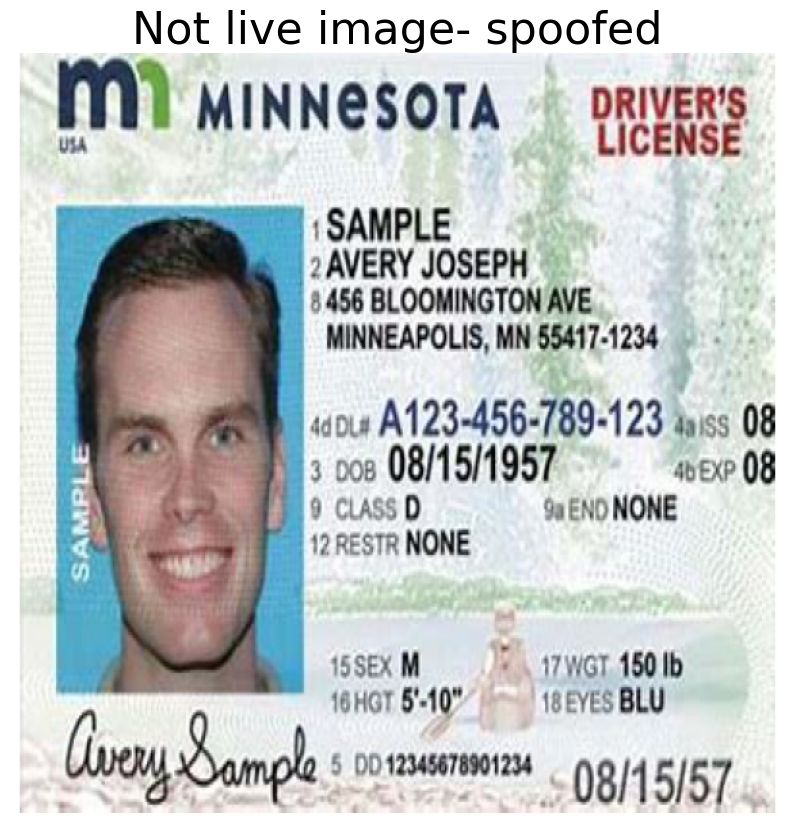

In [17]:
import matplotlib.pyplot as plt
from matplotlib.image import imread

from tensorflow.keras.preprocessing.image import load_img, img_to_array
image_path = "C:/Users/user/Desktop/FYP/3d_face_spoofing/test-images/__results___23_1.png"
image = load_img(image_path, target_size=(224, 224))
image_array = img_to_array(image)
image_array /= 255.0  

threshold = 0.5  
prediction = model.predict(np.expand_dims(image_array, axis=0))[0]
print(prediction)

k=""
if prediction > threshold:
    k="Not live image- spoofed"
else:
    k="Live image"

image_path = 'C:/Users/user/Desktop/FYP/3d_face_spoofing/test-images/__results___23_1.png'
img = imread(image_path)

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.imshow(img, cmap='gray')
ax.set_title(k, fontsize=32)
ax.axis('off')
ax.set_aspect('auto')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
[0.9999989]


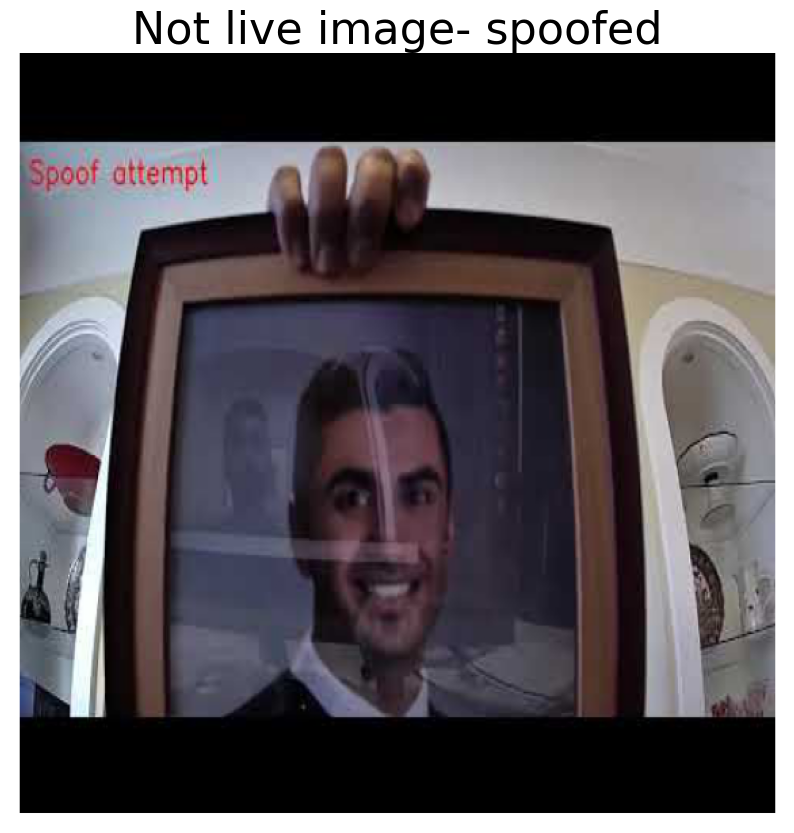

In [18]:
import matplotlib.pyplot as plt
from matplotlib.image import imread

from tensorflow.keras.preprocessing.image import load_img, img_to_array
image_path = "C:/Users/user/Desktop/FYP/3d_face_spoofing/test-images/__results___24_1.png"
image = load_img(image_path, target_size=(224, 224))
image_array = img_to_array(image)
image_array /= 255.0  

threshold = 0.5  
prediction = model.predict(np.expand_dims(image_array, axis=0))[0]
print(prediction)

k=""
if prediction > threshold:
    k="Not live image- spoofed"
else:
    k="Live image"

img = imread(image_path)

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.imshow(img, cmap='gray')
ax.set_title(k, fontsize=32)
ax.axis('off')
ax.set_aspect('auto')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
[0.9968054]


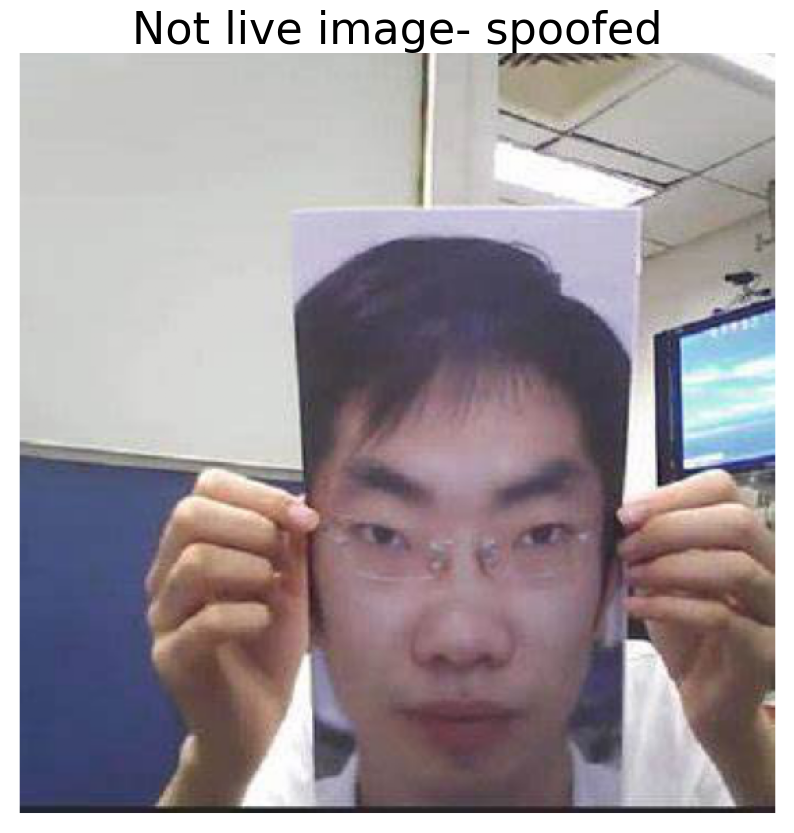

In [19]:
import matplotlib.pyplot as plt
from matplotlib.image import imread

from tensorflow.keras.preprocessing.image import load_img, img_to_array
image_path = "C:/Users/user/Desktop/FYP/3d_face_spoofing/test-images/__results___25_1.png"
image = load_img(image_path, target_size=(224, 224))
image_array = img_to_array(image)
image_array /= 255.0  

threshold = 0.5  
prediction = model.predict(np.expand_dims(image_array, axis=0))[0]
print(prediction)

k=""
if prediction > threshold:
    k="Not live image- spoofed"
else:
    k="Live Image"

img = imread(image_path)

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.imshow(img, cmap='gray')
ax.set_title(k, fontsize=32)
ax.axis('off')
ax.set_aspect('auto')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
[0.99952114]


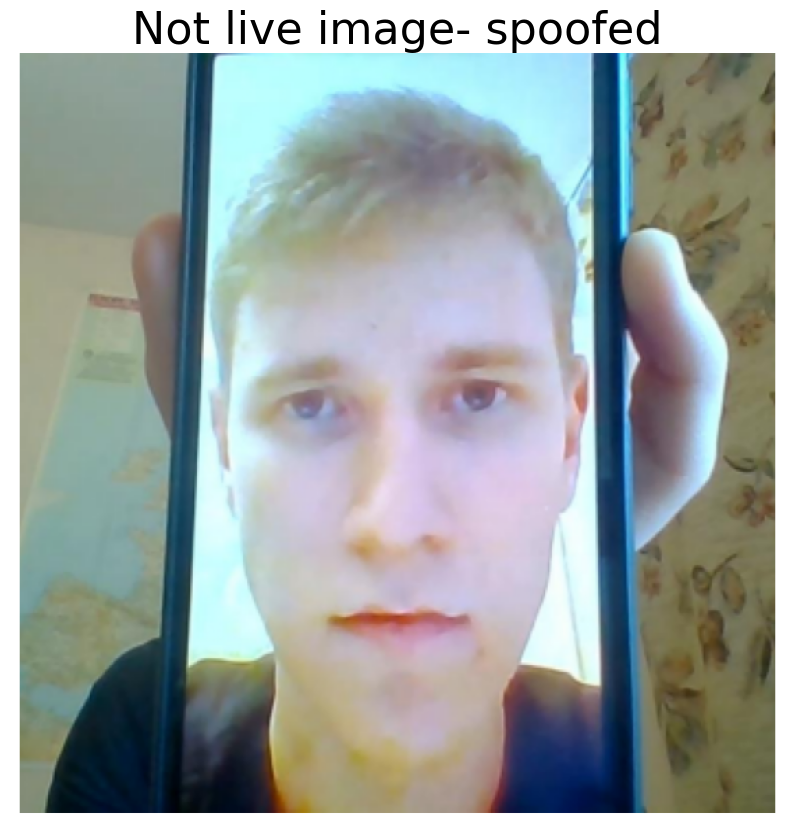

In [20]:
import matplotlib.pyplot as plt
from matplotlib.image import imread

from tensorflow.keras.preprocessing.image import load_img, img_to_array
image_path = "C:/Users/user/Desktop/FYP/3d_face_spoofing/test-images/__results___26_1.png"
image = load_img(image_path, target_size=(224, 224))
image_array = img_to_array(image)
image_array /= 255.0  

threshold = 0.5  
prediction = model.predict(np.expand_dims(image_array, axis=0))[0]
print(prediction)

k=""
if prediction > threshold:
    k="Not live image- spoofed"
else:
    k="Live Image"

img = imread(image_path)

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.imshow(img, cmap='gray')
ax.set_title(k, fontsize=32)
ax.axis('off')
ax.set_aspect('auto')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
[2.7717208e-06]


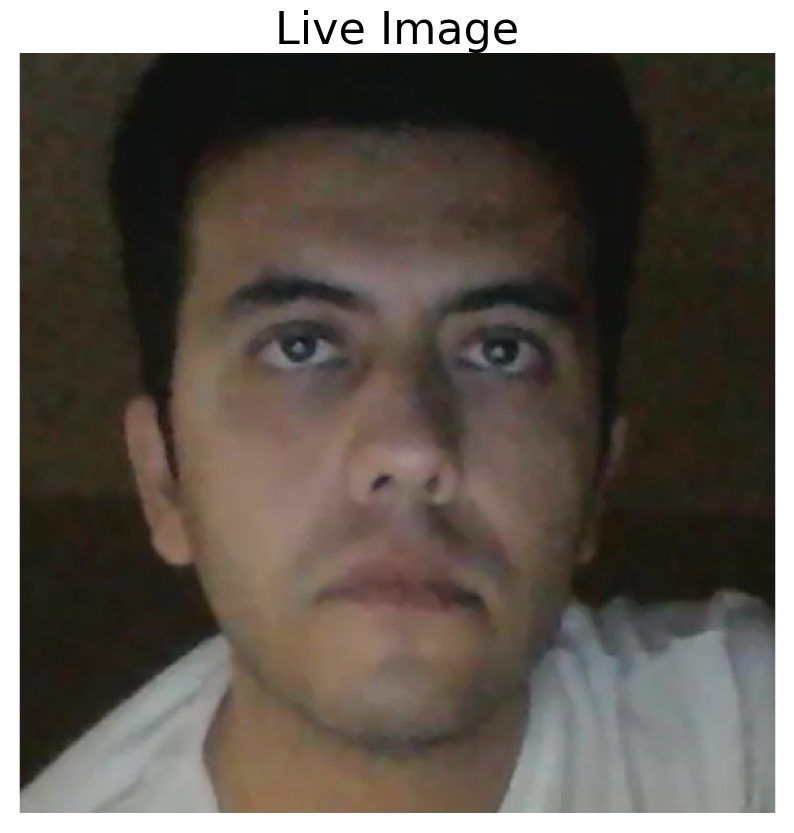

In [21]:
import matplotlib.pyplot as plt
from matplotlib.image import imread

from tensorflow.keras.preprocessing.image import load_img, img_to_array
image_path = "C:/Users/user/Desktop/FYP/3d_face_spoofing/test-images/__results___27_1.png"
image = load_img(image_path, target_size=(224, 224))
image_array = img_to_array(image)
image_array /= 255.0  

threshold = 0.5  
prediction = model.predict(np.expand_dims(image_array, axis=0))[0]
print(prediction)

k=""
if prediction > threshold:
    k="Not live image- spoofed"
else:
    k="Live Image"

img = imread(image_path)

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.imshow(img, cmap='gray')
ax.set_title(k, fontsize=32)
ax.axis('off')
ax.set_aspect('auto')
plt.show()